In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch 
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
import numpy as np
from lime import explanation
from lime import lime_base
import math
from time_lime import LimeTimeSeriesExplainer
from data import load_data
from resnet import resnet34
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, random_split
import torch.optim as optim 
import copy
import argparse

import os
import sklearn 
import scikitplot as skplt

torch.set_num_threads(32)
torch.manual_seed(911) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/home/smjo/anaconda3/envs/xai_timeseries/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: suminjo. Use `wandb login --relogin` to force relogin


In [3]:
ds = load_data('toydata',task='xai',domain='time')
batch_size=1

classification_model_pth = '/home/smjo/xai_timeseries/classification_models/toydata/time/resnet.pt'

train_size = int(0.8 * len(ds))
val_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(ds, [train_size, val_size, test_size])
training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#load classification args 
classification_model = torch.load(classification_model_pth)
class_args = classification_model['args']

net = resnet34(class_args).to(device)
net.load_state_dict(classification_model['model_state_dict'])

task is xai
dataset is toydata
X shape:torch.Size([2000, 192]), y shape:torch.Size([2000, 2])


<All keys matched successfully>

In [4]:
for param in net.parameters():
    param.requires_grad = False 

In [5]:


for k, (data, labels) in enumerate(test_loader):
    #codebook
    net.eval()
    net = net.to(device)
    data = data.unsqueeze(0).to(device)
    y_hat,prob, _,_,_ = net(data)
    # Explain ECG Dataset
    len_ts = data.shape[2]
    
    #Number of perturb indices
    
    idx = 5 # explained instance
    num_slices = 12 # split time series
    num_features = int(192/num_slices) # how many feature contained in explanation
    
    
    index = list(range(num_slices))    
    num_indices = len(index)

    explainer = LimeTimeSeriesExplainer(class_names =['Class0', 'Class1'])
    exp = explainer.explain_instance(data, net, num_features=num_slices, num_samples=5000, num_slices=num_slices,len_ts=192,
                                    replacement_method='total_mean')
    break

In [9]:
exp.as_list()[1]

(10, 1.2692529733322466e-05)

0 0.0662891289861384 green
16 0
10 1.2692529733322466e-05 green
176 160
8 1.0854024926292053e-05 green
144 128
4 1.0118574372675847e-05 green
80 64
5 8.681983177654469e-06 green
96 80
6 8.488427391156988e-06 green
112 96
11 7.633271861310622e-06 green
192 176
2 7.234960413355736e-06 green
48 32
7 6.296458357039425e-06 green
128 112
3 6.222167483885172e-06 green
64 48
9 6.057879005429339e-06 green
160 144
1 5.817584341146772e-06 green
32 16


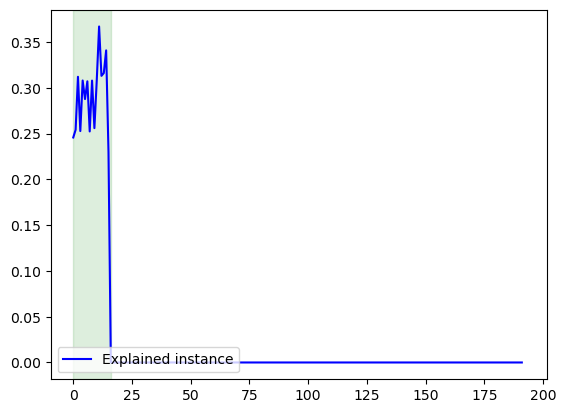

In [16]:
values_per_slice = math.ceil(192 / num_slices)
plt.plot(data.cpu().reshape(192,), color='b', label='Explained instance')
#plt.plot(test_dataset.iloc[15:,:].mean(), color='green', label='Mean of other class')s
plt.legend(loc='lower left')

for i in range(num_slices):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*2))
    print(feature, weight, color)
    print(end, start)
plt.show()

### test sample 전체에 대해 weight 구하기 ###

In [44]:
idx = 5 # explained instance
num_slices = 24 # split time series
num_features = int(192/num_slices) # how many feature contained in explanation


index = list(range(num_slices))    
num_indices = len(index)

weight_dict={ i:0 for i in range(num_slices)}
plt.plot(test_dataset[ecg_test_y[ecg_test_y == 1].index, :].mean(), color='green',
        label='Mean of class 1')
for k, (data, labels) in enumerate(test_loader):
    #codebook
    net.eval()
    net = net.to(device)
    data = data.unsqueeze(0).to(device)
    y_hat,prob, _,_,_ = net(data)
    # Explain ECG Dataset
    len_ts = data.shape[2]
    
    #Number of perturb indices
    
    

    explainer = LimeTimeSeriesExplainer(class_names =['Class0', 'Class1'])
    exp = explainer.explain_instance(data, net, num_features=num_slices, num_samples=5000, num_slices=num_slices,len_ts=192,
                                    replacement_method='total_mean')
    max = -1e-10
    top_important = 0
    for i in range(num_slices):
        feature, weight = exp.as_list()[i]
        if weight >  max:
            max = weight
            top_important = feature
    weight_dict[top_important] +=1
            

plt.

In [43]:

position_rank = sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)
dict(position_rank).keys()

dict_keys([0, 3, 11, 1, 2, 4, 5, 6, 7, 8, 9, 10])

In [42]:
for pos,count in weight_dict.items():
    start = pos * values_per_slice
    end = start + values_per_slice
    plt.axvspan(start , end, color='green', alpha=abs(count*2))

{0: 198, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1}

In [45]:
test_dataset[0]